# Teknik Dimensionality Reduction

*Dimensionality reduction* adalah teknik pengurangan dimensi dari data yang berdimensi tinggi menjadi data yang berdimensi rendah. Tujuannya adalah untuk mengurangi kompleksitas dataset dan meningkatkan kinerja model *machine learning*.

*Dimensionality reduction* dilakukan dengan mengidentifikasi fitur-fitur yang paling penting atau relevan dalam dataset dan mengabaikan fitur-fitur yang kurang penting atau tidak relevan.

Dua teknik yang umum digunakan dalam *dimensionality reduction* adalah *feature selection* dan *feature extraction*.

## Feature Selection

*Feature selection* bertujuan untuk mengurangi jumlah fitur input dengan menggunakan teknik statistik untuk mengidentifikasi fitur-fitur terbaik dan paling relevan, serta mengeluarkan fitur yang tidak relevan dalam dataset untuk model prediksi.

Ada beberapa metode untuk melakukan *feature selection*, antara lain *filter*, *wrapper*, dan *embedded methods*.

### Filter Methods

Metode filter menggunakan teknik statistik untuk "menyaring" atau mengevaluasi properti intrinsik dari setiap fitur input terhadap variabel target untuk mengidentifikasi fitur input mana yang akan dimasukkan ke dalam model *machine learning*.

Berikut adalah contoh implementasi teknik filter dalam Python dengan menggunakan dataset buatan:

#### Feature Variance

Metode ini menghapus fitur yang konstan dan hampir konstan yang tidak memberikan nilai tambah pada model prediksi.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import VarianceThreshold, chi2, mutual_info_classif
from scipy.stats import pearsonr

# Buat dataset buatan
data = {'Feature_1': [1, 2, 3, 4, 5],
        'Feature_2': [1, 2, 2, 2, 2],
        'Feature_3': [2, 2, 2, 2, 2],
        'Feature_4': [1, 0, 1, 0, 1],
        'Target': [0, 0, 1, 1, 0]}
df = pd.DataFrame(data)

# Filter Variance
var_threshold = VarianceThreshold(threshold=0.2)
var_threshold.fit(df)
filtered_var = df.columns[var_threshold.get_support()].tolist()
print("Variance Filtered Features:", filtered_var)

Variance Filtered Features: ['Feature_1', 'Feature_4', 'Target']


Kita akan coba implementasikan pada dataset `breast_cancer`.

In [ ]:
# Load dataset
breast_cancer = load_breast_cancer()

X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.Series(breast_cancer.target)

X.shape

(569, 30)

In [ ]:
# Filter Variance
var_threshold = VarianceThreshold(threshold=0.2)
var_threshold.fit(X)
filtered_var = X.columns[var_threshold.get_support()].tolist()
print("Variance filtered features:", filtered_var)
print("Number of filtered features:", len(filtered_var))

Variance filtered features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'texture error', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area']
Number of filtered features: 11


#### Chi-square

Chi-square digunakan untuk mengukur kekuatan asosiasi antara fitur input dan variabel target. Uji chi-square akan menghitung nilai chi-square untuk setiap fitur input dan menghasilkan p-value yang menunjukkan signifikansi asosiasi tersebut. Fitur input dengan p-value kurang dari ambang batas tertentu akan dianggap signifikan dan dipilih untuk digunakan dalam model.

In [ ]:
# Filter Chi-square
chi2_features, chi2_pvalues = chi2(X, y)
chi2_result = pd.DataFrame({'Features': X.columns, 'Chi2': chi2_features, 'p-value': chi2_pvalues})
filtered_chi2 = chi2_result[chi2_result['p-value'] < 0.05]['Features'].tolist()
print("Chi-square filtered features:", filtered_chi2)
print("Number of filtered features:", len(filtered_chi2))

Chi-square filtered features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']
Number of filtered features: 17


#### Correlation coefficients

Correlation coefficients menunjukkan nilai korelasi antara fitur input dan variabel target.

In [ ]:
# Filter Korelasi Pearson
corr_features = []
for i in range(len(X.columns)):
    for j in range(i+1, len(X.columns)):
        corr, _ = pearsonr(X.iloc[:, i], X.iloc[:, j])
        if abs(corr) > 0.7:
            corr_features.append(X.columns[i])
            corr_features.append(X.columns[j])
filtered_corr = list(set(corr_features))
print("Pearson correlation filtered features:", filtered_corr)
print("Number of filtered features:", len(filtered_corr))

Pearson correlation filtered features: ['mean perimeter', 'fractal dimension error', 'concavity error', 'worst radius', 'worst texture', 'worst concave points', 'worst compactness', 'area error', 'compactness error', 'mean compactness', 'perimeter error', 'concave points error', 'mean radius', 'mean texture', 'worst smoothness', 'worst fractal dimension', 'worst area', 'mean concave points', 'mean smoothness', 'worst perimeter', 'mean concavity', 'mean area', 'worst concavity', 'radius error', 'mean fractal dimension']
Number of filtered features: 25


#### Information gain

Information gain mengukur kontribusi fitur input terhadap memprediksi variabel target.

In [ ]:
# Filter Informasi Gain
mutual_info = mutual_info_classif(X, y, n_neighbors=3)
mi_result = pd.DataFrame({'Features': X.columns, 'Mutual_Info': mutual_info})
filtered_mi = mi_result.sort_values('Mutual_Info', ascending=False).head(5)['Features'].tolist()
print("Mutual information filtered features:", filtered_mi)
print("Number of filtered features:", len(filtered_mi))

Mutual information filtered features: ['worst perimeter', 'worst area', 'worst radius', 'mean concave points', 'worst concave points']
Number of filtered features: 5


### Wrapper Methods

Metode wrapper membuat subset fitur acak dari dataset dan melatih model machine learning menggunakan subset tersebut. Kemudian, model tersebut dievaluasi dan skornya dicatat. Selanjutnya, fitur yang kurang penting dalam subset tersebut dihapus dan model dilatih kembali menggunakan subset baru. Proses ini diulang beberapa kali, di mana fitur yang kurang penting dihapus dan fitur baru ditambahkan untuk meningkatkan performa model.

Berikut adalah contoh implementasi Python dari metode Wrapper dengan menggunakan dataset breast cancer dari contoh sebelumnya:

In [ ]:
# Import library
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Forward Feature Selection

Metode yang dimulai dengan tidak memiliki fitur dalam model dan pada setiap iterasi, fitur yang paling meningkatkan model ditambahkan hingga penambahan variabel baru tidak meningkatkan kinerja model.

In [ ]:
# Forward feature selection
fs = SequentialFeatureSelector(LogisticRegression(solver='liblinear'), n_features_to_select=5)
fs.fit(X_train, y_train)
X_train_forward = fs.transform(X_train)
X_test_forward = fs.transform(X_test)

print("Selected features using Forward Feature Selection: ", data.feature_names[fs.get_support()].tolist())

Selected features using Forward Feature Selection:  ['mean radius', 'mean perimeter', 'worst texture', 'worst area', 'worst compactness']


#### Backward Feature Elimination

Backward Feature Elimination dimulai dengan semua fitur, dan menghapus fitur yang kurang signifikan pada setiap iterasi hingga tidak ada peningkatan yang diamati.

In [ ]:
# Backward feature elimination
be = SequentialFeatureSelector(LogisticRegression(solver='liblinear'), n_features_to_select=5, direction='backward')
be.fit(X_train, y_train)
X_train_backward = be.transform(X_train)
X_test_backward = be.transform(X_test)

print("Selected features using Backward Feature Elimination: ", data.feature_names[be.get_support()].tolist())

Selected features using Backward Feature Elimination:  ['mean radius', 'mean perimeter', 'worst radius', 'worst texture', 'worst area']


#### Recursive Feature Elimination

Recursive Feature Elimination membuat model berulang kali dan menyimpan fitur terbaik atau terburuk pada setiap iterasi sampai semua fitur habis, lalu menilai fitur-fitur berdasarkan urutan eliminasi mereka.

In [ ]:
# Recursive feature elimination
rfe = RFECV(LogisticRegression(solver='liblinear'))
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

print("Selected features using Recursive Feature Elimination: ", data.feature_names[rfe.get_support()])

Selected features using Recursive Feature Elimination:  ['mean radius' 'mean texture' 'mean perimeter' 'mean smoothness'
 'mean compactness' 'mean concavity' 'mean concave points' 'mean symmetry'
 'mean fractal dimension' 'radius error' 'texture error' 'perimeter error'
 'area error' 'concavity error' 'concave points error' 'symmetry error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### Embedded Methods

Metode embedded  melibatkan pembuatan model machine learning dan pemilihan fitur dilakukan pada saat yang sama. Sebagai contoh, beberapa algoritma machine learning seperti Regresi Lasso (L1 Regularization) dan Decision Tree memiliki kemampuan bawaan untuk memilih fitur yang paling signifikan selama proses training.

Berikut adalah contoh implementasi Python dari metode embedded dengan menggunakan dataset breast cancer dari contoh sebelumnya:

In [ ]:
# Import library
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

#### Decision tree

Decision tree membangun pohon keputusan yang optimal dengan menggunakan fitur-fitur yang paling signifikan pada setiap tingkat. Fitur-fitur yang kurang signifikan secara otomatis dihilangkan saat membangun model.

In [ ]:
# Decision Tree
dtc = DecisionTreeClassifier()
model = SelectFromModel(dtc)
model.fit(X, y)
X_dtc = model.transform(X)
print("Selected features using Decision Tree: ", data.feature_names[model.get_support()])

Selected features using Decision Tree:  ['worst radius' 'worst texture' 'worst concave points']


#### L1 Regularization

L1 Regularization menggunakan regularisasi L1 pada model regresi linear untuk menekan koefisien fitur yang tidak signifikan menjadi nol, sehingga fitur-fitur ini secara otomatis dihapus dari model.

In [ ]:
# Lasso Regression (L1 Regularization)
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_lasso = model.transform(X)
print("Selected features using Lasso Regression: ", data.feature_names[model.get_support()])

Selected features using Lasso Regression:  ['mean area' 'area error' 'worst texture' 'worst perimeter' 'worst area']


#### L2 Regularization

L2 Regularization menggunakan regularisasi L2 pada model regresi linear untuk menekan koefisien fitur yang tidak signifikan. Fitur-fitur dengan koefisien yang kecil secara otomatis dihapus dari model.

In [ ]:
# Ridge Regression (L2 Regularization)
ridge = Ridge(alpha=0.1)
ridge.fit(X, y)
model = SelectFromModel(ridge, prefit=True)
X_ridge = model.transform(X)
print("Selected features using Ridge Regression: ", data.feature_names[model.get_support()])

Selected features using Ridge Regression:  ['mean compactness' 'mean concavity' 'mean concave points' 'radius error'
 'smoothness error' 'concavity error' 'worst smoothness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


#### Elastic Net

Elastic Net menggabungkan regularisasi L1 dan L2 untuk menekan koefisien fitur yang tidak signifikan. Fitur-fitur dengan koefisien yang kecil secara otomatis dihapus dari model.

In [ ]:
# Elastic Net
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model = SelectFromModel(enet)
model.fit(X, y)
X_enet = model.transform(X)
print("Selected features using Elastic Net: ", data.feature_names[model.get_support()])

Selected features using Elastic Net:  ['worst texture' 'worst perimeter']


## Feature Extraction

### Principal Component Analysis (PCA)

PCA bertujuan untuk menemukan hubungan antara fitur-fitur pada data yang berdimensi tinggi, sehingga setiap data dapat direpresentasikan dengan sejumlah fitur yang lebih sedikit namun tetap menjaga informasi yang terkandung dalam data.

PCA mengurangi dimensi data dengan cara menggabungkan beberapa fitur yang saling berkorelasi menjadi satu fitur baru yang disebut principal component.

#### PCA: Step-by-step

Kita akan mencoba mengimplementasikan step-by-step PCA dengan menggunakan iris dataset.

In [ ]:
# Import library
import pandas as pd
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [ ]:
print("Dataset dimension:", X.shape, end='\n\n')

X.head()

Dataset dimension: (150, 4)



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Dataset iris sekarang disimpan dalam bentuk matriks 150 x 4, di mana setiap kolom adalah fitur yang berbeda, dan setiap baris mewakili sampel bunga yang terpisah. Setiap baris sampel dapat digambarkan sebagai vektor 4-dimensi.


In [ ]:
X.iloc[0]

sepal length (cm)    5.1
sepal width (cm)     3.5
petal length (cm)    1.4
petal width (cm)     0.2
Name: 0, dtype: float64

**Langkah 1:** Menstandarisasi data.

In [ ]:
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)

**Langkah 2:** Menghitung covariance matrix atau correlation matrix untuk dataset yang telah distandarisasi.

***Apa perbedaan kovarian dan korelasi?***

Kovarian menunjukkan seberapa besar perubahan dari dua random variabel secara bersama-sama. Semakin besar (positif) nilai kovariannya menunjukkan bahwa nilai X yang besar berkoresponden dengan nilai-nilai Y yang besar juga. Sebaliknya jika nilainya semakin kecil kearah negatif maka nilai X yang besar berkoresponden dengan nilai Y yang kecil.

Sedangkan korelasi menjelaskan kekuatan hubungan antara dua random variabel secara linear. Dalam hal ini, korelasi itu adalah bentuk normalisasi dari kovaria. Jadi, jika kovarian tidak punya batas maksimal dan minimal, korelasi punya batas [-1, 1] yang membantu kita untuk membuat derajat hubungan antara satu variabel dengan variabel yang lain.

Menghitung covariance matrix:

In [ ]:
import numpy as np

# Menghitung covariance matrix
cov_mat = np.cov(X_std.T)

print('Covariance matrix: \n%s' %cov_mat)

Covariance matrix: 
[[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]


Menghitung correlation matrix:

In [ ]:
# Menghitung correlation matrix
cor_mat = np.corrcoef(X_std.T)

print('Correlation matrix: \n%s' %cor_mat)

Correlation matrix: 
[[ 1.         -0.11756978  0.87175378  0.81794113]
 [-0.11756978  1.         -0.4284401  -0.36612593]
 [ 0.87175378 -0.4284401   1.          0.96286543]
 [ 0.81794113 -0.36612593  0.96286543  1.        ]]


**Langkah 3:** Menghitung eigenvector dan eigenvalue dari covariance matrix atau correlation matrix.

Menghitung eigenvector dan eigenvalue dari covariance matrix:

In [ ]:
# Menghitung eigenvector dan eigenvalue dari covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]

Eigenvalues 
[2.93808505 0.9201649  0.14774182 0.02085386]


Menghitung eigenvector dan eigenvalue dari correlation matrix:

In [ ]:
# Menghitung eigenvector dan eigenvalue dari correlation matrix
eig_vals, eig_vecs = np.linalg.eig(cor_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]

Eigenvalues 
[2.91849782 0.91403047 0.14675688 0.02071484]


**Langkah 4:** Mengurutkan eigenvalues dalam urutan menurun dan memilih k eigenvector terbesar yang sesuai dengan k eigenvalues terbesar.

In [ ]:
# Membuat list dari nilai pasangan eigenvalue dan eigenvector
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Mengurutkan nilai eigenvalue dan eigenvector dari tinggi ke rendah
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Melihat hasil ranking eigenvalue
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.9184978165319952
0.9140304714680693
0.14675687557131453
0.020714836428619453


**Langkah 5:** Menghitung explained variance.

Setelah mengurutkan eigenpvalues, pertanyaan selanjutnya adalah "berapa banyak komponen utama yang akan kita pilih untuk subspace fitur baru kita?"

Salah satu ukuran yang berguna adalah "explained variance," yang dapat dihitung dari eigenvalue. Explained variance memberitahu kita seberapa banyak informasi (variansi) yang dapat dikaitkan dengan setiap komponen utama.

In [ ]:
# Menghitung cummulative variance
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

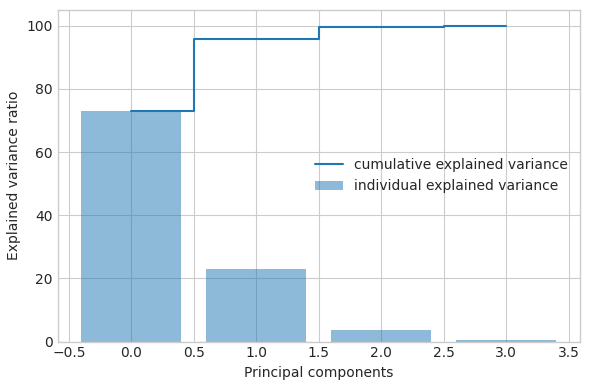

In [ ]:
# Plotting cummulative variance
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

Grafik di atas menunjukkan bahwa sebagian besar variansi (72,77% dari variansi secara tepat) dapat dijelaskan oleh PC1 saja. PC2 masih memiliki informasi yang signifikan (23,03%), sementara PC3 dan PC5 dapat dihilangkan tanpa kehilangan terlalu banyak informasi. Dengan demikian, PC1 dan PC2 secara bersama-sama mengandung 95,8% informasi.

**Langkah 6:** Membuat matriks proyeksi W dari k eigenvector yang dipilih.

Di sini, kita mengurangi ruang fitur 4-dimensi menjadi subruang fitur 2-dimensi, dengan memilih dua eigenvector teratas dengan eigenvalue tertinggi untuk membuat matriks eigenvector d × k-dimensi kita yaitu W.

In [ ]:
# Membuat matriks proyeksi W
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


**Langkah 7:** Mengubah dataset asli X melalui W untuk mendapatkan subspace fitur baru Y yang berdimensi k.

In [ ]:
# Transform dataset X melalui W
Y = X_std.dot(matrix_w)

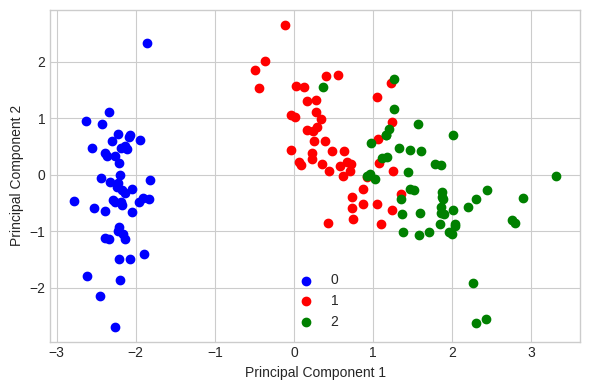

In [ ]:
import matplotlib.pyplot as plt

with plt.style.context('seaborn-whitegrid'):
  plt.figure(figsize=(6, 4))
  for lab, col in zip((0, 1, 2),
                      ('blue', 'red', 'green')):
    plt.scatter(Y[y==lab, 0],
                Y[y==lab, 1],
                label=lab,
                c=col)
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.legend(loc='lower center')
  plt.tight_layout()
  plt.show()

#### PCA: Shortcut

Kita telah belajar tentang pengaplikasian PCA step-by-step. Dalam library `scikit-learn`, sudah ada function yang dapat kita gunakan untuk implementasi PCA.

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

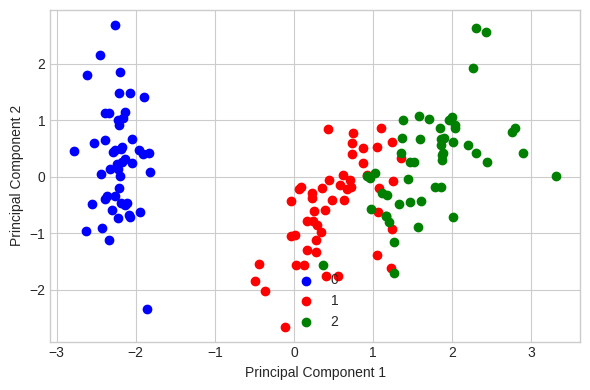

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip((0, 1, 2),
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

# Hands-on: Klasifikasi Internet Ads

Kita akan mengimplementasikan hierarchical clustering dengan dataset ["Internet Advertisements"](https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements) dari UCI Machine Learning.

Dataset Internet Advertisements merupakan dataset yang berisi informasi tentang karakteristik dari iklan-iklan di Internet yang terdiri dari 3.279 sampel dan 1.557 fitur.

Fitur-fitur ini meliputi jenis font, ukuran font, warna latar belakang, ukuran iklan, posisi iklan di halaman web, dan sebagainya. Setiap sampel diidentifikasi sebagai iklan ("ad") atau bukan iklan ("noad").

Tujuan latihan ini adalah untuk mengembangkan model machine learning yang dapat memprediksi apakah sebuah gambar merupakan "ad" atau "noad" berdasarkan fitur-fitur iklan tersebut.

## 1. Persiapan

Pertama-tama, kita perlu mengimpor library yang dibutuhkan dan meload datasetnya.

In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/internet_ads/ad.data", header=None, sep=",", low_memory=False)

# Mengecek 5 baris data teratas
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


## 2. Data Exploration

Kita perlu melakukan eksplorasi data untuk mengetahui karakteristik dari data yang akan kita analisis.

In [ ]:
# Dimensi data
df.shape

(3279, 1559)

Dataset ini memiliki 3.279 baris dan 1.559 kolom, sehingga merupakan dataset dengan dimensi yang sangat tinggi.

In [ ]:
df.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       3279 non-null   object
 1   1       3279 non-null   object
 2   2       3279 non-null   object
 3   3       3279 non-null   object
 4   4       3279 non-null   int64 
 5   5       3279 non-null   int64 
 6   6       3279 non-null   int64 
 7   7       3279 non-null   int64 
 8   8       3279 non-null   int64 
 9   9       3279 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 256.3+ KB


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,170,94,0.5529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3275,101,140,1.3861,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3276,23,120,5.2173,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3277,?,?,?,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


In [ ]:
df.iloc[3277][1]

'   ?'

## 3. Data Preprocessing

### Data Cleansing

Inspeksi pada dataset menunjukkan dataset ini memiliki nilai-nilai yang hilang dan jenis data yang beragam pada 4 kolom pertama, sehingga kita perlu membersihkan dan mengubah jenis datanya sebelum kita dapat melakukan PCA.

Pada empat kolom pertama, terdapat nilai data string `   ?` yang merepresentasikan missing value dengan jumlah whitespace yang beragam. Kita akan membersihkannya dengan menggunakan fungsi `strip()`.

In [ ]:
# Mengambil kolom dengan tipe objek dan menggunakan strip
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())

df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
3274,170,94,0.5529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3275,101,140,1.3861,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3276,23,120,5.2173,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3277,?,?,?,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3278,40,40,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


Kemudian kita akan merubah missing value tersebut menjadi `nan`.

In [ ]:
import numpy as np

# Replace missing values with NaN
df.iloc[:, :-1]  = df.iloc[:, :-1].replace('?', np.nan)

df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
3274,170,94,0.5529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3275,101,140,1.3861,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3276,23,120,5.2173,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3277,NaN,NaN,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3278,40,40,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


Kita mengubah nilai string angka menjadi numerik...

In [ ]:
# Convert string data to numeric
df.iloc[:, :-1]  = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
3274,170.0,94.0,0.5529,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3275,101.0,140.0,1.3861,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3276,23.0,120.0,5.2173,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3277,NaN,NaN,NaN,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3278,40.0,40.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


... dan menghapus baris yang memiliki nilai `nan`.

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273,30.0,30.0,1.0000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3274,170.0,94.0,0.5529,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3275,101.0,140.0,1.3861,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3276,23.0,120.0,5.2173,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


Kita mendapatkan dataset yang sudah dibersihkan dengan 2.359 baris dan 1.559 kolom. Selanjutnya, kita akan memisahkan fitur dan label.

In [ ]:
# Split features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

### Feature Scaling

Sebelum melakukan PCA, kita perlu melakukan feature scaling terlebih dahulu untuk menghindari pengaruh dari skala data yang berbeda-beda.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Perform feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Kemudian kita lakukan splitting dataset ke dalam training dan testing dataset.

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

## Benchmark Model

Kita akan membuat benchmark model dengan melatih algoritma Logistic Regression dengan dataset yang ada.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Fit model
model0 = LogisticRegression(solver='liblinear')
model0.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [ ]:
# Prediksi test data
pred = model0.predict(X_test)

# Cek accuracy
print('Accuracy of benchmark model: {:.4f}'.format(model0.score(X_test, y_test)))

Accuracy of benchmark model: 0.9725


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression

# Fit model
model0 = LogisticRegression(solver='liblinear')
model0.fit(X_train, y_train)

# Prediksi test data
pred = model0.predict(X_test)

# Cek accuracy
print('Accuracy of benchmark model: {:.4f}'.format(model0.score(X_test, y_test)))

Accuracy of benchmark model: 0.9555


## Model dengan PCA

### Melakukan PCA

Setelah melakukan pembersihan dan feature scaling, kita dapat melanjutkan dengan melakukan PCA pada dataset.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

Sekarang kita akan menentukan jumlah principal component dengan memplot cumulative variance yang dijelaskan oleh semua PC. Variansi yang dijelaskan ditentukan oleh metode `pca.explained_variance_ratio_`.

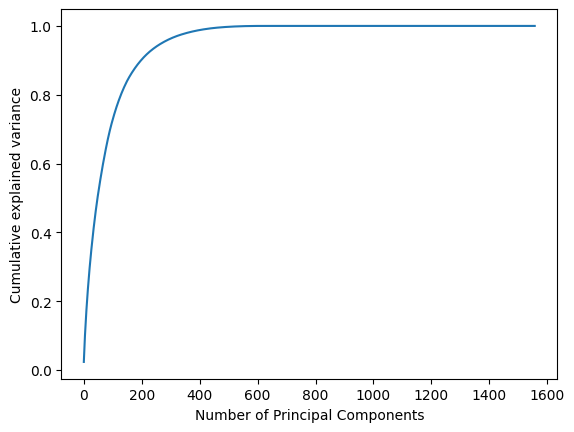

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative explained variance');

Dari plot, kita dapat melihat bahwa 250 komponen utama pertama menjelaskan lebih dari 90% variasi. Berdasarkan grafik ini, kita dapat memutuskan berapa banyak komponen utama yang ingin kita miliki tergantung pada variabilitas yang dijelaskan.

Dalam hal ini, kita menggunakan 250 komponen untuk melakukan pelatihan ulang PCA.

In [ ]:
from sklearn.decomposition import PCA

# Defining PCA with 250 components
pca = PCA(n_components=250)

# Fitting PCA on the training set
pca.fit(X_train)

PCA(n_components=250)

In [ ]:
# Transforming training set and test set
X_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# Mengecek perubahan shape training dan testing data
print("Original shape of Training set: ", X_train.shape)
print("Original shape of Test set: ", X_test.shape)
print("Transformed shape of training set:", X_pca.shape)
print("Transformed shape of test set:", X_test_pca.shape)

Original shape of Training set:  (1887, 1558)
Original shape of Test set:  (472, 1558)
Transformed shape of training set: (1887, 250)
Transformed shape of test set: (472, 250)


## 4. Training Model

Setelah membagi dataset, kita akan membuat model Machine Learning menggunakan algoritma Logistic Regression dan melakukan pelatihan pada data latih.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Fitting a Logistic Regression Model
model = LogisticRegression(solver='liblinear')
model.fit(X_pca, y_train)

LogisticRegression(solver='liblinear')

## 5. Evaluasi Model

Setelah model dilatih, selanjutnya kita akan melakukan evaluasi model menggunakan data uji.

In [ ]:
# Predicting with the pca model
pred = model.predict(X_test_pca)

# Print accuracy
print('Accuracy of model prediction on test set: {:.4f}'.format(model.score(X_test_pca, y_test)))

Accuracy of model prediction on test set: 0.9682


In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         ad.       0.93      0.87      0.90        78
      nonad.       0.97      0.99      0.98       394

    accuracy                           0.97       472
   macro avg       0.95      0.93      0.94       472
weighted avg       0.97      0.97      0.97       472



Hasilnya menunjukkan bahwa model memiliki akurasi sekitar 97%, lebih baik dari akurasi model benchmark sebesar 95% dan cukup baik untuk memprediksi apakah sebuah gambar merupakan "ad" atau "noad".